# Проект "Телекоммуникации"
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

Данные представлены в 4 таблицах:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Оператор предоставляет два основных типа услуг:

* Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Информация о договорах актуальна на 1 февраля 2020.**

## Загрузка данных.

Импортируем и загрузим все необходимые инструменты и библиотеки.

In [ ]:
! pip install snakecase -q

In [ ]:
! pip install phik -q

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import snakecase
import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

import warnings
warnings.filterwarnings('ignore')


RANDOM_STATE = 131123

Загрузим и назовем наши датасеты.

In [ ]:
contract_df=pd.read_csv('/datasets/contract_new.csv')
personal_df=pd.read_csv('/datasets/personal_new.csv')
internet_df=pd.read_csv('/datasets/internet_new.csv')
phone_df=pd.read_csv('/datasets/phone_new.csv')

## Исследовательский анализ данных.

Создадим функцию дающую краткое представление о датасетах:
- отображает случайную выборку из 5 строк;
- показыват общую информацию;
- описывает числовые и категориальные признаки;
- показывает явные пропуски и дубликаты.

In [ ]:
def open_df(df):
    display(df.sample(5))
    print()
    display(df.info())
    print()
    display(df.describe(include='all'))
    print()
    print('Явные пропуски в данных')
    print(df.isna().sum()/len(df))
    print()
    print('Явные дубликаты в данных')
    print(df.duplicated().sum())


### Датафрейм с данными по контрактам.

Рассмотрим первый датасет с контрактами.

In [ ]:
open_df(contract_df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5671,6370-ZVHDV,2015-01-01,No,Two year,No,Bank transfer (automatic),25.30,1543.3
130,2876-GZYZC,2019-01-01,No,Month-to-month,Yes,Electronic check,85.95,1173.22
6844,6897-UUBNU,2017-09-01,2018-03-01,Month-to-month,No,Mailed check,89.65,537.9
2858,9512-PHSMG,2019-04-01,No,Month-to-month,Yes,Mailed check,20.55,207.56
6747,5245-VDBUR,2015-10-01,No,One year,No,Mailed check,35.45,1843.4



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,1996-DBMUS,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN



Явные пропуски в данных
customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: float64

Явные дубликаты в данных
0


В датасете 7043 строк и 8 признаков. По признаку `EndDate` предлагаю сразу создать целевой признак -`ClientLeft`(1-клиент ушел, 0-клиент остался).  
Также данных присутствуют признаки с неверными типами данных - изменим это. Для дальнейшего feature engeneering заменим все значения No в признаке `EndDate` на актуальную дату, прописанную в описании проекта `2020-02-01` и сразу на его основе создадим признак - `Duration`.

Хотя явных пропусков и дубликатов не выявлено, в столбце TotalCharges самым повторяющимся значением является пустая строка, рассмотрим этот момент подробнее.

In [ ]:
#создали целевой признак.
contract_df['ClientLeft'] = contract_df['EndDate'].apply(lambda x: 1 if x != 'No' else 0)

In [ ]:
contract_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ClientLeft
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2,0
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4,0
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6,0
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8,0


In [ ]:
#изменили тип данных и заполнили пропуски.
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'], errors='coerce')
contract_df['EndDate'] = contract_df['EndDate'].replace('No','2020-02-01')
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'])
contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'], errors='coerce')

In [ ]:
#создали признак Duration
contract_df['Duration'] =(contract_df['EndDate'] - contract_df['BeginDate']) / np.timedelta64 ( 1 , 'D')

In [ ]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   ClientLeft        7043 non-null   int64         
 9   Duration          7043 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 550.4+ KB


In [ ]:
#рассмотрим пропуски в переменной TotalCharges.
contract_df.loc[contract_df['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ClientLeft,Duration
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0.0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0.0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0.0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0.0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0.0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0.0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0.0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0.0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0.0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0.0


Пропуски в этой переменной возникли из-за того что это абсолютно новые клиенты, оформившие договора в день проведения исследования. Предлагаю заполнить их значениями из переменной MonthlyCharges.

In [ ]:
contract_df['TotalCharges'] = contract_df['TotalCharges'].fillna(contract_df['MonthlyCharges'])

### Датафрейм с персональными данными.

In [ ]:
open_df(personal_df)

,customerID,gender,SeniorCitizen,Partner,Dependents
6855,8738-JOKAR,Female,0,No,No
3575,9501-UKKNL,Male,0,No,No
1985,8901-HJXTF,Female,0,Yes,Yes
2900,0679-IDSTG,Female,1,Yes,Yes
6141,5385-SUIRI,Male,1,Yes,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,1996-DBMUS,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN



Явные пропуски в данных
customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64

Явные дубликаты в данных
0


В датасете 7043 строк и 5 признаков с личной информацией о клиенте. ID клиента, его пол, пенсионер ли он, женат/замужем и есть ли дети. Явных дубликатов и пропусков нет. В столбце `SeniorCitizen` для красоты данных можем изменить тип данных на категориальный.

In [ ]:
personal_df['SeniorCitizen'] = personal_df['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

### Датафрейм с интернет услугами.

In [ ]:
open_df(internet_df)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3564,5322-TEUJK,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
3675,5181-OABFK,DSL,Yes,Yes,Yes,No,No,No
4369,4929-BSTRX,DSL,No,No,No,No,Yes,No
2179,2691-NZETQ,Fiber optic,No,No,No,No,Yes,No
5335,9129-UXERG,Fiber optic,No,Yes,No,Yes,Yes,Yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,1996-DBMUS,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Явные пропуски в данных
customerID          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64

Явные дубликаты в данных
0


В данном датафрейме 5517 строк и 8 признаков - id пользователя и наличие у него определнных интернет услуг. Явных пропусков и дубликатов в данных не выявлено.

### Датафрейм с данными по телефонии.

In [ ]:
open_df(phone_df)

,customerID,MultipleLines
3979,1088-CNNKB,Yes
1054,6242-MBHPK,No
5877,3985-HOYPM,No
760,6092-QZVPP,No
5081,2344-JMOGN,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,1996-DBMUS,No
freq,1,3390



Явные пропуски в данных
customerID       0.0
MultipleLines    0.0
dtype: float64

Явные дубликаты в данных
0


В последнем датафрейме всего 6361 строка и два признака - id пользователя и наличие у него мультиканального соединения.

**Общий вывод:** В данном разделе проведено предварительное исследование и обработка данных датасетов. Там где необходимо был изменен тип данных и заполнены пропуски. В двух датасетах - Интернет услуги и Телефония - меньшее количество строк, что говорит нам о том, что не все клиенты пользуются одним или другим видами услуг.  
Более детальный обзор данных предстоит после их объединения в следующем параграфе.

## Объединение данных и EDA.

### Объединение данных.

Объеденим наши датафреймы по индексу - Id клиента.

In [ ]:
data = contract_df \
    .merge(personal_df, how='outer', on='customerID')\
    .merge(internet_df, how='outer', on='customerID')\
    .merge(phone_df, how='outer', on='customerID')\
    .reset_index(drop=True)

In [ ]:
open_df(data)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ClientLeft,Duration,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
2146,8894-JVDCV,2014-12-01,2020-02-01,One year,Yes,Credit card (automatic),115.05,7133.10,0,1888.0,...,No,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2602,1135-HIORI,2014-10-01,2020-02-01,One year,Yes,Electronic check,111.45,7560.77,0,1949.0,...,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
1875,9637-CDTKZ,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),114.10,8708.11,0,2191.0,...,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3386,1474-JUWSM,2015-04-01,2020-02-01,One year,Yes,Electronic check,68.40,4363.92,0,1767.0,...,Yes,No,DSL,Yes,No,No,Yes,No,Yes,Yes
725,6549-YMFAW,2019-05-01,2020-02-01,Month-to-month,Yes,Mailed check,21.25,191.25,0,276.0,...,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   ClientLeft        7043 non-null   int64         
 9   Duration          7043 non-null   float64       
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   object        
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 

None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ClientLeft,Duration,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043.000000,7043.000000,...,7043,7043,5517,5517,5517,5517,5517,5517,5517,6361
unique,7043,77,67,3,2,4,NaN,NaN,NaN,NaN,...,2,2,2,2,2,2,2,2,2,2
top,1996-DBMUS,2014-02-01 00:00:00,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,NaN,...,No,No,Fiber optic,No,No,No,No,No,No,No
freq,1,366,5942,3875,4171,2365,NaN,NaN,NaN,NaN,...,3641,4933,3096,3498,3088,3095,3473,2810,2785,3390
first,NaN,2013-10-01 00:00:00,2014-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-02-01 00:00:00,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2115.377573,0.156325,898.555729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2112.678861,0.363189,683.130510,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,19.050000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,436.750000,0.000000,276.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Явные пропуски в данных
customerID          0.000000
BeginDate           0.000000
EndDate             0.000000
Type                0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.000000
ClientLeft          0.000000
Duration            0.000000
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
InternetService     0.216669
OnlineSecurity      0.216669
OnlineBackup        0.216669
DeviceProtection    0.216669
TechSupport         0.216669
StreamingTV         0.216669
StreamingMovies     0.216669
MultipleLines       0.096834
dtype: float64

Явные дубликаты в данных
0


Для удобства переведем все названия столбцов в "змеиный регистр".

In [ ]:
data.columns = data.columns.to_series().apply(snakecase.convert)
data.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'client_left',
       'duration', 'gender', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines'],
      dtype='object')

### Заполнение пропусков.

Как я писал выше, не все клиенты используют ряд предложенных услуг. Считаю разумным заполнить пропуски в последних 8 столбцах значением - 'No'.

In [ ]:
data = data.fillna('No')

### EDA

Рассмотрим все численные + дата признаки более подробно: построим гистограммы для каждого признака и опишем распределение.

#### Заключение и расторжение контрактов по годам.

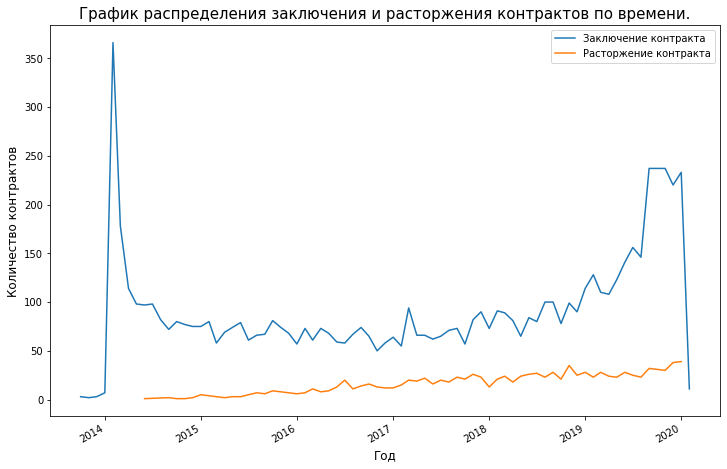

In [ ]:
from datetime import datetime
plt.figure(figsize=(12, 8))

#график числа заключения контрактов по годам
data.begin_date.value_counts().plot()
#график расторжения контрактов по годам (исключая дату '2020-02-01')
value_to_exclude = datetime.strptime('2020-02-01', '%Y-%m-%d')
dates_filtered = data['end_date'][data['end_date'] != value_to_exclude]
dates_filtered.value_counts().plot()
plt.title("График распределения заключения и расторжения контрактов по времени.",
          fontsize=15)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество контрактов', fontsize=12)
plt.legend(['Заключение контракта', 'Расторжение контракта'])

plt.show()

На графике заметно, что в момент начала ведения статистики в 2014 году - возможно начала деятельности организации - был большой приток клиентов. далее наблюдалось относительное плато от года в год до 2019 года, потом резкий рост.  
Процент расторжения контрактов увеличивается ежегодно.

#### Распределение месячных и общих оплат, длительности контракта

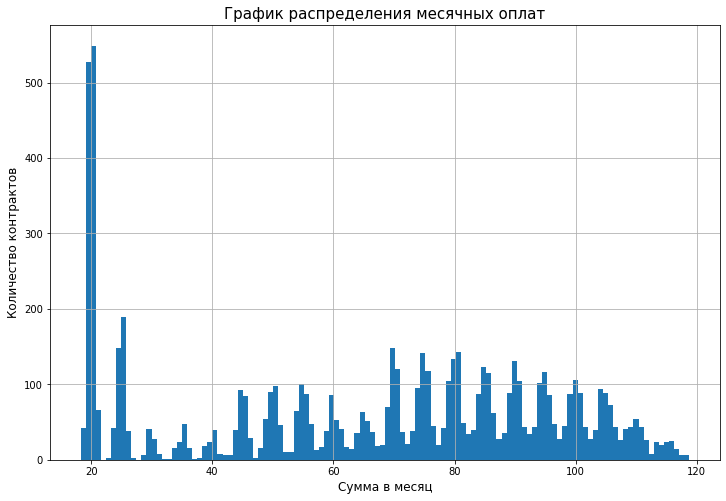

In [ ]:
plt.figure(figsize=(12, 8))
data.monthly_charges.hist(bins=120)
plt.title("График распределения месячных оплат",
          fontsize=15)
plt.xlabel('Сумма в месяц', fontsize=12)
plt.ylabel('Количество контрактов', fontsize=12)
plt.show()

Самое большое колличество контрактов стоимостью 20 ед. в месяц. Далее распределение относительно ровное - пики каждые 5 ед., что свидетельствует о ценах на тарифы кратныx 5. Стоимость разнится от 20 до 120.

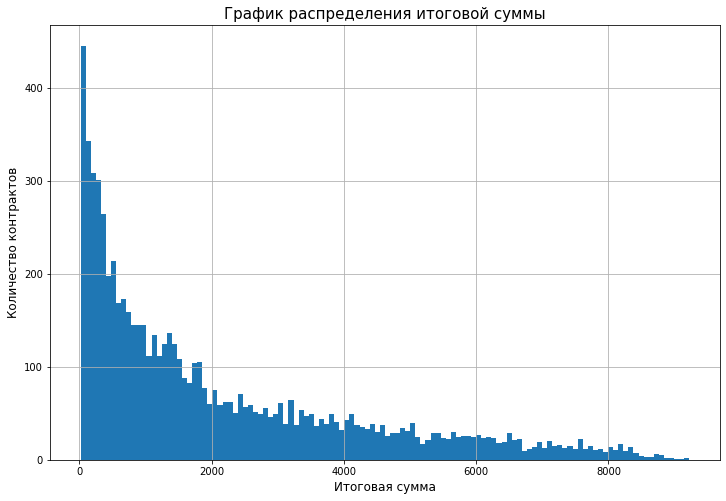

In [ ]:
plt.figure(figsize=(12, 8))
data.total_charges.hist(bins=120)
plt.title("График распределения итоговой суммы",
          fontsize=15)
plt.xlabel('Итоговая сумма', fontsize=12)
plt.ylabel('Количество контрактов', fontsize=12)
plt.show()

Распределение итоговой суммы потраченной на услуги скошено влево и имеет длинный хвост. Больше всего люди потратили в общем около 1000 ед. на услуги провайдера.

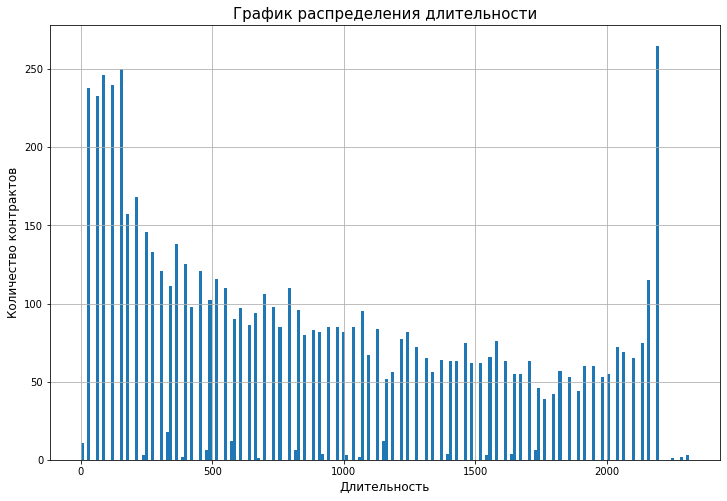

In [ ]:
plt.figure(figsize=(12, 8))
data.duration.hist(bins=200)
plt.title("График распределения длительности",
          fontsize=15)
plt.xlabel('Длительность', fontsize=12)
plt.ylabel('Количество контрактов', fontsize=12)
plt.show()

У компании довольно много клиентов, заключивших с ней относительно недолгие договора. Но также есть большое количество клиентов, имеющих долгосрочные отношения с провайдером - 2200 дней.

#### Категориальные признаки, касаемые контракта

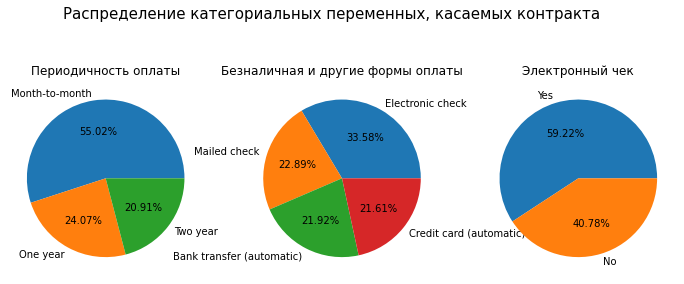

In [ ]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('Распределение категориальных переменных, касаемых контракта', fontsize=15)

ax1 = fig.add_subplot(131)
ax1.pie(data.type.value_counts().values,
        labels = data.type.unique(),
        autopct='%1.2f%%')
ax1.set_title('Периодичность оплаты')

ax2 = fig.add_subplot(132)
ax2.pie(data.payment_method.value_counts().values,
        labels = data.payment_method.unique(),
        autopct='%1.2f%%')
ax2.set_title('Безналичная и другие формы оплаты')

ax3 = fig.add_subplot(133)
ax3.pie(data.paperless_billing.value_counts().values,
        labels = data.paperless_billing.unique(),
        autopct='%1.2f%%')
ax3.set_title('Электронный чек')

plt.show()


Больше всего контрактов с помесячной оплатой, безналичным платежом с электронным чеком. Оплат кредиткой, через банковский перевод и электронную почту примерно поровну.

#### Категориальные признаки, касаемые личных данных клиента.

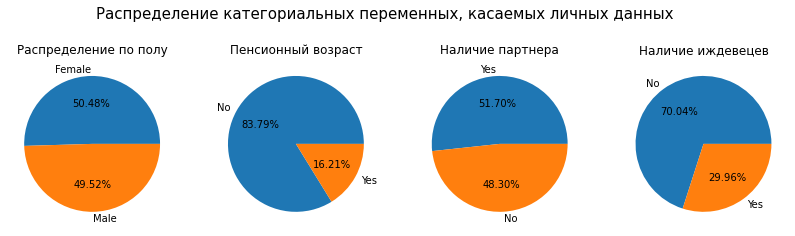

In [ ]:
fig = plt.figure(figsize=(14,4))
fig.suptitle('Распределение категориальных переменных, касаемых личных данных', fontsize=15)

ax1 = fig.add_subplot(141)
ax1.pie(data.gender.value_counts().values,
        labels = data.gender.unique(),
        autopct='%1.2f%%')
ax1.set_title('Распределение по полу')

ax2 = fig.add_subplot(142)
ax2.pie(data.senior_citizen.value_counts().values,
        labels = data.senior_citizen.unique(),
        autopct='%1.2f%%')
ax2.set_title('Пенсионный возраст')

ax3 = fig.add_subplot(143)
ax3.pie(data.partner.value_counts().values,
        labels = data.partner.unique(),
        autopct='%1.2f%%')
ax3.set_title('Наличие партнера')

ax4 = fig.add_subplot(144)
ax4.pie(data.dependents.value_counts().values,
        labels = data.dependents.unique(),
        autopct='%1.2f%%')
ax4.set_title('Наличие иждевецев')


plt.show()


Мужчин и женщин в датасете представлено поровну. Людей пенсионного возраста сравнительно немного. Одиноких и людей с партнерами примерно одинаковое количество. Больше бездетных и без людей на иждевении.

#### Интернет услуги и телефония.

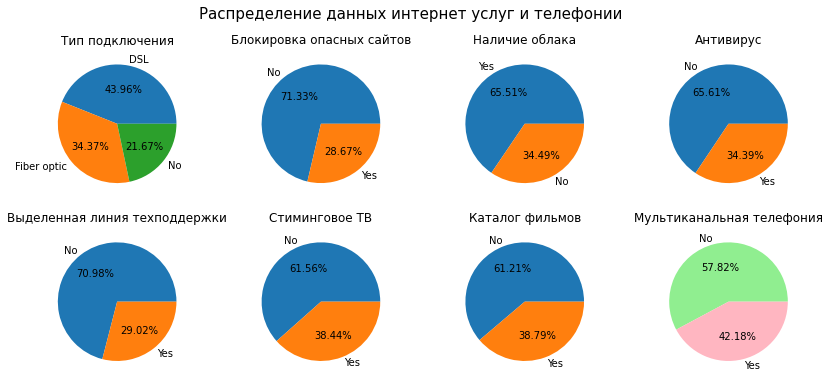

In [ ]:
fig = plt.figure(figsize=(14,6))
fig.suptitle('Распределение данных интернет услуг и телефонии', fontsize=15)

ax1 = fig.add_subplot(241)
ax1.pie(data.internet_service.value_counts().values,
        labels = data.internet_service.unique(),
        autopct='%1.2f%%')
ax1.set_title('Тип подключения')

ax2 = fig.add_subplot(242)
ax2.pie(data.online_security.value_counts().values,
        labels = data.online_security.unique(),
        autopct='%1.2f%%')
ax2.set_title('Блокировка опасных сайтов')

ax3 = fig.add_subplot(243)
ax3.pie(data.online_backup.value_counts().values,
        labels = data.online_backup.unique(),
        autopct='%1.2f%%')
ax3.set_title('Наличие облака')

ax4 = fig.add_subplot(244)
ax4.pie(data.device_protection.value_counts().values,
        labels = data.device_protection.unique(),
        autopct='%1.2f%%')
ax4.set_title('Антивирус')

ax5 = fig.add_subplot(245)
ax5.pie(data.tech_support.value_counts().values,
        labels = data.tech_support.unique(),
        autopct='%1.2f%%')
ax5.set_title('Выделенная линия техподдержки')

ax6 = fig.add_subplot(246)
ax6.pie(data.streaming_tv.value_counts().values,
        labels = data.streaming_tv.unique(),
        autopct='%1.2f%%')
ax6.set_title('Стиминговое ТВ')

ax7 = fig.add_subplot(247)
ax7.pie(data.streaming_movies.value_counts().values,
        labels = data.streaming_movies.unique(),
        autopct='%1.2f%%')
ax7.set_title('Каталог фильмов')

ax8 = fig.add_subplot(248)
ax8.pie(data.multiple_lines.value_counts().values,
        labels = data.multiple_lines.unique(),
        autopct='%1.2f%%', colors = ['lightgreen', 'lightpink']
)
ax8.set_title('Мультиканальная телефония')

plt.show()

Самое популярное интернет соединение - DLS. У 20% клиентов отсутствует подключение к интернету. Самая популярная доп-услуга - облачное хранилище, остальные распределены практически одинаково среди интернет пользователей. Мультикональная телефония присутсвует у 42% клиентов.

#### Исследование признаков на мультиколлинеарность.

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'client_left', 'duration']


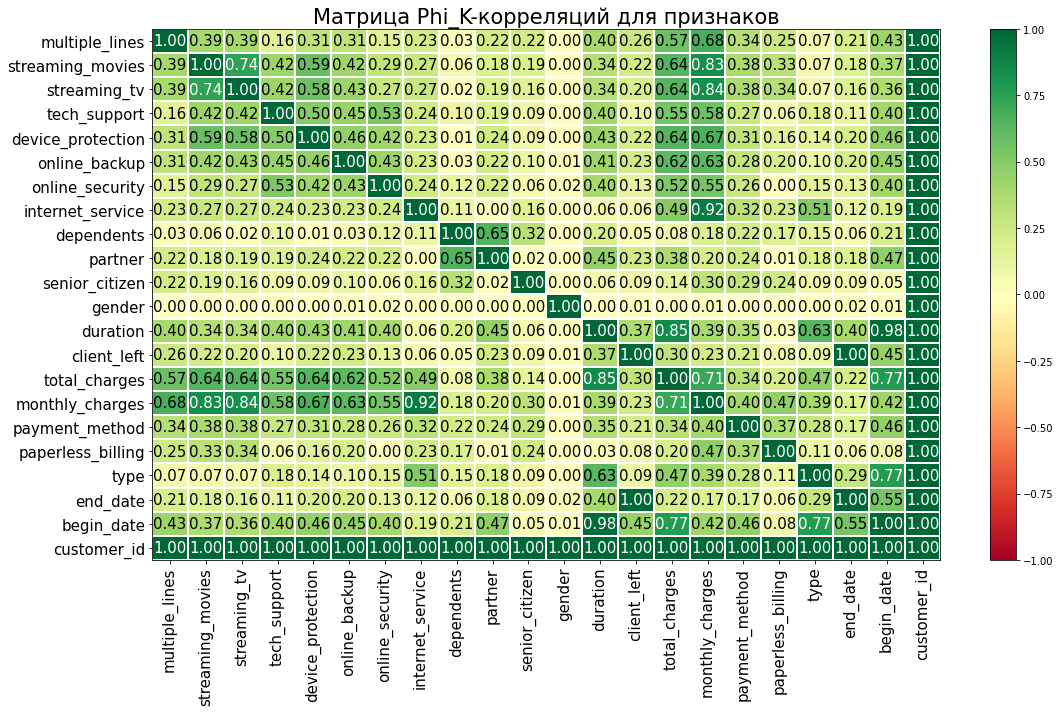

In [ ]:
def Pirson_heat():

        corr_matrix = data.phik_matrix()
        plot_correlation_matrix(corr_matrix.values,
                                x_labels=corr_matrix.columns,
                                y_labels=corr_matrix.index,
                                title="Матрица Phi_K-корреляций для признаков",
                                fontsize_factor=1.5,
                                figsize=(16, 10));
        plt.tight_layout()

Pirson_heat()

Из таблицы следует, что переменные `monthly_charges` и  `total_charges` мультиколлинеарны с некоторыми другими - от них стоит избавиться. Также следует удалить бесполезные признаки - `customer_id`, `begin_date`, `end_date`. Также, на мой взгляд необходимо избавиться от признака `streaming_movies` он высоко коллерирует с `streaming_tv`.

In [ ]:
data=data.drop(columns=['monthly_charges','total_charges','customer_id','begin_date','end_date','streaming_movies'])

#### Сбалансированность целевого признака.

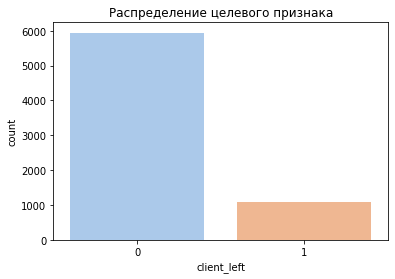

In [ ]:
sns.countplot(x='client_left', data=data, palette='pastel')
plt.title('Распределение целевого признака')
plt.show()

Присутствует очевидный дисбаланс классов. Но так как ключевая метрика в нашем исследовании - ROC-AUC, то балансировать данные не надо.

## Обучение моделей

Для нашего исследования я выделил три модели - Логистическую Регрессию, Случайный Лес и Кэтбуст.  

Для начала выделим целевой признак и разделим выборку на тестовую и тренировочную.

In [ ]:
#Выделяем тагет и фичи
X = data.drop('client_left', axis=1)
y=data['client_left']

#Определяем числовые и категориальные признаки
num_features = ['duration']
cat_features = data.drop(['duration', 'client_left'], axis=1).columns.tolist()

# разделяем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

#проверям размер выборок
train_to_general = X_train.shape[0]/data.shape[0]*100
test_to_general = X_test.shape[0]/data.shape[0]*100

print(f"Обучающая выборка составляет {train_to_general:.2f}% от генеральной")
print(f"Тестовая выборка составляет {test_to_general:.2f}% от генеральной")

Обучающая выборка составляет 75.00% от генеральной
Тестовая выборка составляет 25.00% от генеральной


Масштабируем и закодируем признаки для будущего построения моделей:

In [ ]:
# Создаем предобработчики для числовых и категориальных признаков
num_transformer = StandardScaler()
cat_transformer_lr = OneHotEncoder(handle_unknown='error', drop='first')
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# Создаем ColumnTransformer для Логистической Регрессии
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer_lr, cat_features)
    ])

# Создаем ColumnTransformer для Рандомного Леса
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

Переходим к непосредственной тренировке моделей. Тренировать их будем через пайплайн

### Logistic Regression

In [ ]:
# Создаем pipeline для модели Logistic Regression
lr_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_lr),
    ('feature_selection', SelectFromModel(LogisticRegression(random_state=RANDOM_STATE), threshold=0.05)),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])
# Прописываем сетку парметров GridSearch
lr_param_grid = {
    'classifier__C': [0.1, 1.0],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

lr_grid_search = GridSearchCV(lr_pipe, lr_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
lr_grid_search.fit(X_train, y_train)

print(f'LogisticRegression лучшие параметры: {lr_grid_search.best_params_}')
print(f'LogisticRegression лучшая оценка: {lr_grid_search.best_score_}')


LogisticRegression лучшие параметры: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
LogisticRegression лучшая оценка: 0.7531249146951808


### Random Forest.

In [ ]:
# Создаем pipeline для модели RandomForest
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=RANDOM_STATE), threshold=0.05)),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [4, 6, 8],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(rf_pipe, rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

print(f'RandomForest лучшие параметры: {rf_grid_search.best_params_}')
print(f'RandomForest лучшая оценка: {rf_grid_search.best_score_}')

RandomForest лучшие параметры: {'classifier__max_depth': 8, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
RandomForest лучшая оценка: 0.8794626475058189


### CatBoost  Classifier.

Модель Кэтбуст обучим без пайплайна, а также без предварительного масштабирования и кодирования признаков.

In [ ]:
param_fixed={'random_seed':RANDOM_STATE,
             'cat_features':cat_features,
             'verbose':False}


cat_param_grid = {'learning_rate': [0.1,0.2],
              'depth': [6, 8]}


model_cb = CatBoostClassifier(**param_fixed)

In [ ]:
cat_grid_search = GridSearchCV(model_cb, cat_param_grid, cv=5, error_score='raise', scoring='roc_auc', n_jobs=-1)
cat_grid_search.fit(X_train, y_train)

print(f'CatBoost лучшие параметры: {cat_grid_search.best_params_}')
print(f'CatBoost лучшая оценка: {cat_grid_search.best_score_}')

CatBoost лучшие параметры: {'depth': 6, 'learning_rate': 0.1}
CatBoost лучшая оценка: 0.9178997950359596


### Результаты обучения.

Построим таблицу и сравним результаты обучения трех моделей.

In [ ]:
index= ['LogisticRegression', 'RandomForestRegression', 'CatBoostRegression']
res=[lr_grid_search.best_score_,rf_grid_search.best_score_,cat_grid_search.best_score_]

results= pd.DataFrame({'ROC_AUC':res},index=index)
results

,ROC_AUC
LogisticRegression,0.753125
RandomForestRegression,0.879463
CatBoostRegression,0.917900


С большим отрывом в показателях контрольной метрики лидирует Кэтбуст. Протестируем данную модель.

## Тестирование лучшей модели.

In [ ]:
best_model = cat_grid_search.best_estimator_

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

best_model_pred = best_model.predict(X_test)
best_model_accuracy = accuracy_score(y_test, best_model_pred)

print(f'ROC AUC на тестовой выборке: {roc_auc:.4f}')
print(f'Точность на тестовой выборке: {best_model_accuracy:.4f}')

ROC AUC на тестовой выборке: 0.9254
Точность на тестовой выборке: 0.9233


Достаточный результат контрольной метрики на тестовой выборке.

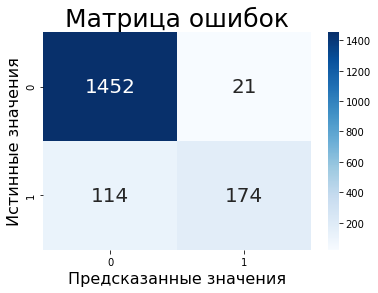

In [ ]:
conf_matrix = confusion_matrix(y_test, best_model_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d',annot_kws={"fontsize":20}, cmap='Blues')
plt.ylabel('Истинные значения', fontsize=16)
plt.xlabel('Предсказанные значения', fontsize=16)
plt.title('Матрица ошибок', fontsize=25)
plt.show()

Модель правильно предсказала 130 из 148 ушедших клиентов, а также 1455 из 1613 оставшихся. Считаю это хорошим результатом.  
Создадим график значимости признаков.

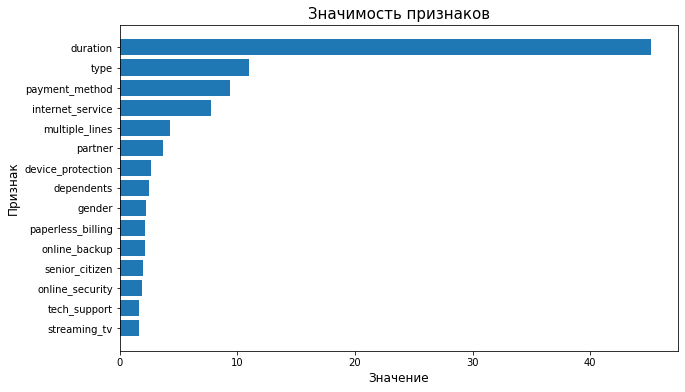

In [ ]:
feature_importance = best_model.feature_importances_
feature_names = X_train.columns

# Создайте DataFrame для удобства работы с данными
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Выведите график важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Значение',fontsize=12)
plt.ylabel('Признак',fontsize=12)
plt.title('Значимость признаков',fontsize=15)
plt.show()

Как видно из полученной схемы - самым важным признаком для прогнозиорвания оттока клиентов является длительность контракта, далее идт тип контракта и способ оплаты.

## Вывод.

Нам было поручно задание построить лучшую модель прогнозирующую отток клиентов оператора связи "Теледом". В ходе выполнения работы были осуществлены следующие этапы:
- Загрузка и знакомство с данными,
- Исследовательский анализ каждого датафрейма до объединения,
- Анализ общего датафрейма, заполнение пропусков, создание новых и выбор полезных фичей,
- Подготовка к обучению моделей,
- Обучение моделей и выбор лучшей,
- Тестирование лучшей модели.

На этапе предобработки был выделен целевой признак - client_left (1-клиент ушел, 0-клиент остался) и на основе даты заключения и раторжения контракта был создан признак `duration`.
Данные были приведены к нужным форматам. Там где необходимо заполнены пропуски.  
Далее датасеты были объединены в общий, а также был произведен разведовательный анализ данных, по итогу которого были выявлены следующие закономерности
- в момент основания компании был большой приток клиентов. далее наблюдалось относительное плато от года в год до 2019 года, потом резкий рост.
- процент расторжения контрактов увеличивается ежегодно.

В количественных признаках:
- cамое большое колличество контрактов стоимостью 20 ед. в месяц. Далее распределение относительно ровное - пики каждые 5 ед., что свидетельствует о ценах на тарифы кратныx 5. Стоимость разнится от 20 до 120.
- Распределение итоговой суммы потраченной на услуги скошено влево и имеет длинный хвост. Больше всего люди потратили в общем около 1000 ед. на услуги провайдера.

В категориальных признаках:
- Больше всего контрактов с помесячной оплатой, безналичным платежом с электронным чеком. Оплат кредиткой, через банковский перевод и электронную почту примерно поровну.
- Мужчин и женщин в датасете представлено поровну. Людей пенсионного возраста сравнительно немного. Одиноких и людей с партнерами примерно одинаковое количество. Больше бездетных и без людей на иждевении.
- Самое популярное интернет соединение - DLS. У 20% клиентов отсутствует подключение к интернету. Самая популярная доп-услуга - облачное хранилище, остальные распределены практически одинаково среди интернет пользователей. Мультикональная телефония присутсвует у 42% клиентов.

Целевой признак несбалансирован - ушедших клиентов в 6 раз меньше, чем оставшихся (но на продолжение исследования это никак не влияет, так как наша ключевая метрика - roc-auc, а она устойчива к дисбалансу классов).

После проверки на мультиколлинеарность были удалены следующие признаки - `monthly_charges`,`total_charges` и `streaming_movie`. Также за ненадобностью были удалены признаки `'customer_id', 'begin_date', 'end_date'`.

Далее были обучены три модели - Логистическая Регрессия, Случайный Лес и Кэтбуст, также для них были подобрано лучшее сочетание гиперпараметров сетодом Гридсёрч.  
Лучший результат показал алгоритм Кэтбуст - 0.9179, на тестовой выборке- 0.9254. Вторая метрика (точность) - 0.9233, говорит о том, что модель ошибается менее чем в 0,8 случаях из 10. Модель правильно предсказала 130 из 148 ушедших клиентов, а также 1455 из 1613 оставшихся.  
После выделения важности признаков выявили, что самым важным признаком для прогнозиорвания оттока клиентов является длительность контракта, далее идт тип контракта и способ оплаты.

По завершению исследования можно объявить следующие рекомендации заказчику:
- для прогнозирования оттока клиентов стоит воспользоваться предобученной моделью Кэтбуст с сеткой гиперпарамтров - {'depth': 6, 'learning_rate': 0.1},
- сотрудникам компании в первую очередь стоит обратить внимание длительность контракта и его тип.